## Bias testing 
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'LGBM $T_{\mathrm{mean \ daily}}$'
TRUE = 'Target $T_{\mathrm{mean \ daily}}$'

In [3]:
PRED

'LGBM $T_{\\mathrm{mean \\ daily}}$'

### Imports

In [4]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [5]:
if PREDICTAND == 'tasmin':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/grid_search/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2_dem_sa_doy.nc")
    
if PREDICTAND == 'tasmax':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/grid_search/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2_dem_sa_doy.nc")
    
if PREDICTAND == 'tasmean':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/base_models/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2m_dem_doy.nc")    

y_pred


<xarray.Dataset> Size: 226MB
Dimensions:  (time: 1826, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x) float64 226MB ...

In [6]:
y_pred = y_pred - 273.15

In [7]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_tasmin_2m_temperature_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_tasmax_2m_temperature_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [10]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2020


In [11]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [12]:
y_true

<xarray.DataArray 'tasmean' (time: 1826, y: 96, x: 161)> Size: 113MB
array([[[10.06369   ,  9.825775  ,  9.550079  , ...,  8.7117    ,
          9.25293   ,  9.128937  ],
        [ 9.7388    ,  9.48941   ,  9.148376  , ...,  7.2322693 ,
          7.5288696 ,  6.274292  ],
        [ 9.55423   ,  9.218109  ,  8.879974  , ...,  6.3025513 ,
          5.1644287 ,  4.231262  ],
        ...,
        [ 4.3807983 ,  4.4526978 ,  4.3851013 , ..., -2.1247253 ,
         -2.0166626 , -1.8519592 ],
        [ 4.5255127 ,  4.5939026 ,  4.4677124 , ..., -1.5125427 ,
         -1.4614563 , -1.4924622 ],
        [ 4.7895203 ,  4.918579  ,  4.742157  , ..., -1.4219055 ,
         -1.5484009 , -1.7154541 ]],

       [[10.33728   , 10.041199  ,  9.779144  , ..., 11.216064  ,
         11.627502  , 11.047791  ],
        [ 9.855988  ,  9.627838  ,  9.470245  , ...,  9.825958  ,
          9.895905  ,  8.558563  ],
        [ 9.858856  ,  9.419952  ,  9.19104   , ...,  8.641022  ,
          7.345825  ,  6.568451  ],
...
        [ 1.1291199 ,  1.0311584 ,  0.8732605 , ...,  2.4204712 ,
          2.5972595 ,  3.0231323 ],
        [ 1.0886536 ,  1.0751648 ,  0.87301636, ...,  3.6161194 ,
          3.978302  ,  4.1756897 ],
        [ 1.3735657 ,  1.4538879 ,  1.197876  , ...,  4.541809  ,
          4.575836  ,  4.458832  ]],

       [[ 2.324646  ,  2.1434326 ,  1.9787903 , ..., 13.167084  ,
         13.665649  , 13.616547  ],
        [ 1.9729614 ,  1.5584412 ,  1.6370544 , ..., 12.347626  ,
         12.814331  , 12.362122  ],
        [ 1.8825989 ,  1.4822998 ,  1.3814087 , ..., 12.472656  ,
         11.874481  , 11.518127  ],
        ...,
        [ 1.0103455 ,  0.9259949 ,  0.81155396, ..., -0.05187988,
          0.10299683,  0.34005737],
        [ 1.1213074 ,  1.039917  ,  0.84017944, ...,  0.5721741 ,
          0.7281494 ,  0.7475281 ],
        [ 1.4971008 ,  1.4839172 ,  1.2037659 , ...,  0.766449  ,
          0.7253418 ,  0.5571594 ]]], dtype=float32)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 15kB 2016-01-01 ... 2020-12-30

In [13]:
y_pred

<xarray.DataArray 'tasmean' (time: 1826, y: 96, x: 161)> Size: 226MB
array([[[ 9.83272398,  9.68455584,  9.14063459, ...,  8.55402406,
          8.90320597,  8.46882879],
        [ 9.57831357,  9.1348488 ,  8.80332342, ...,  7.24115667,
          7.45422929,  5.91341945],
        [ 9.47751825,  9.07239927,  8.95730038, ...,  6.47222697,
          5.23474379,  4.35299041],
        ...,
        [ 3.3234408 ,  3.39428179,  3.37945045, ..., -2.28234312,
         -1.94817191, -1.76003148],
        [ 3.53610027,  3.49254271,  3.58914416, ..., -1.75588391,
         -1.5442504 , -1.38525648],
        [ 3.78082173,  4.04464806,  3.90714787, ..., -1.3636    ,
         -1.31708987, -1.42801073]],

       [[10.11616945,  9.95835343,  9.77485728, ..., 10.46076669,
         10.63081864, 10.08105265],
        [ 9.80197946,  9.39177871,  9.06072418, ...,  9.26775618,
          9.29557766,  8.27564309],
        [ 9.60764221,  9.35199962,  8.81713954, ...,  8.25553085,
          7.1755021 ,  6.22007723],
...
        [ 0.7656023 ,  0.78398828,  0.73217805, ...,  1.65085153,
          1.86571215,  2.53617344],
        [ 0.74605896,  0.78001247,  0.69881508, ...,  2.6846314 ,
          2.94540065,  3.10443407],
        [ 0.84058259,  0.89474829,  0.78056228, ...,  3.30555619,
          3.19367007,  3.11607041]],

       [[ 3.15060404,  3.01367654,  2.62662647, ..., 12.52429347,
         12.82309027, 12.83093046],
        [ 2.56829689,  2.28972045,  2.2372522 , ..., 11.67534608,
         11.95655134, 11.55691614],
        [ 2.23717158,  1.67503602,  1.83683893, ..., 11.50940091,
         10.98257205, 10.38898474],
        ...,
        [ 1.49628229,  1.48675464,  1.32975591, ..., -0.54294261,
         -0.21813352,  0.18438209],
        [ 1.41198818,  1.42298474,  1.24790501, ...,  0.20193711,
          0.4187111 ,  0.51473604],
        [ 1.59211821,  1.70334847,  1.44906363, ...,  0.34512631,
          0.27743959,  0.55869912]]])
Coordinates:
  * time     (time) datetime64[ns] 15kB 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82

In [14]:
### calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [15]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [16]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [17]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 1.00
R2 on daily anomalies: 0.95


### Coefficient of determination: Spatially

In [18]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred.x), len(y_pred.y)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, i, j] = r2_score(point_true, point_pred)
        r2[1, i, j] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_129093/3738331126.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_129093/3738331126.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


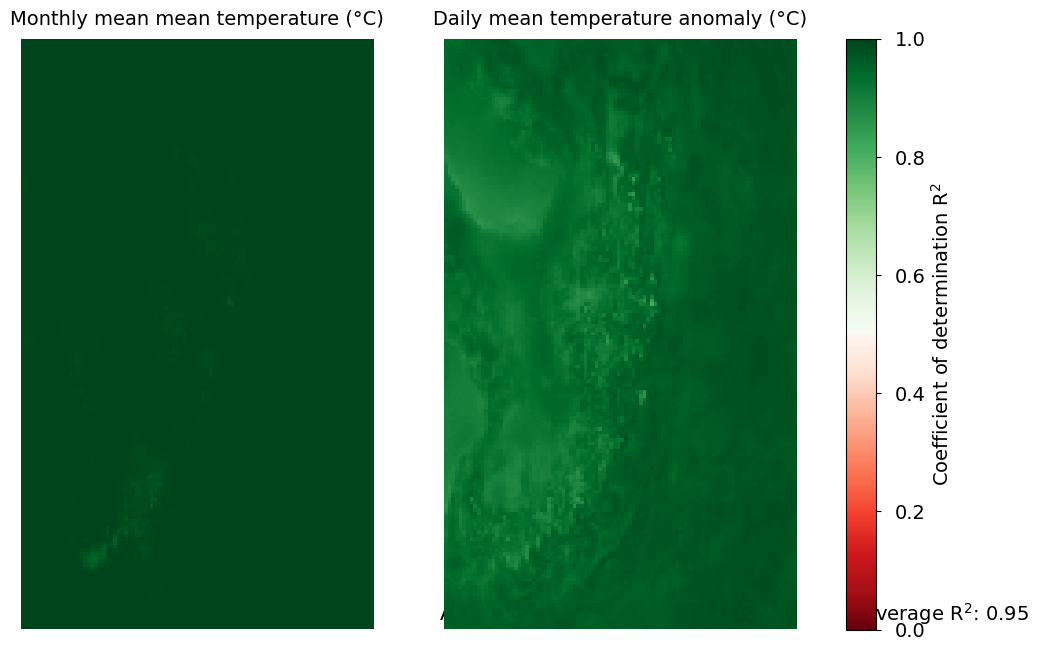

In [41]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = 0, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [21]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average bias of tasmean: -0.05°C


In [22]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average MAE of tasmean: 0.18°C


In [23]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average RMSE of tasmean: 0.24°C


In [24]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(2016): 1.00
(2017): 1.00
(2018): 1.00
(2019): 1.00
(2020): 1.00
Yearly average Pearson correlation coefficient for tasmean: 1.00


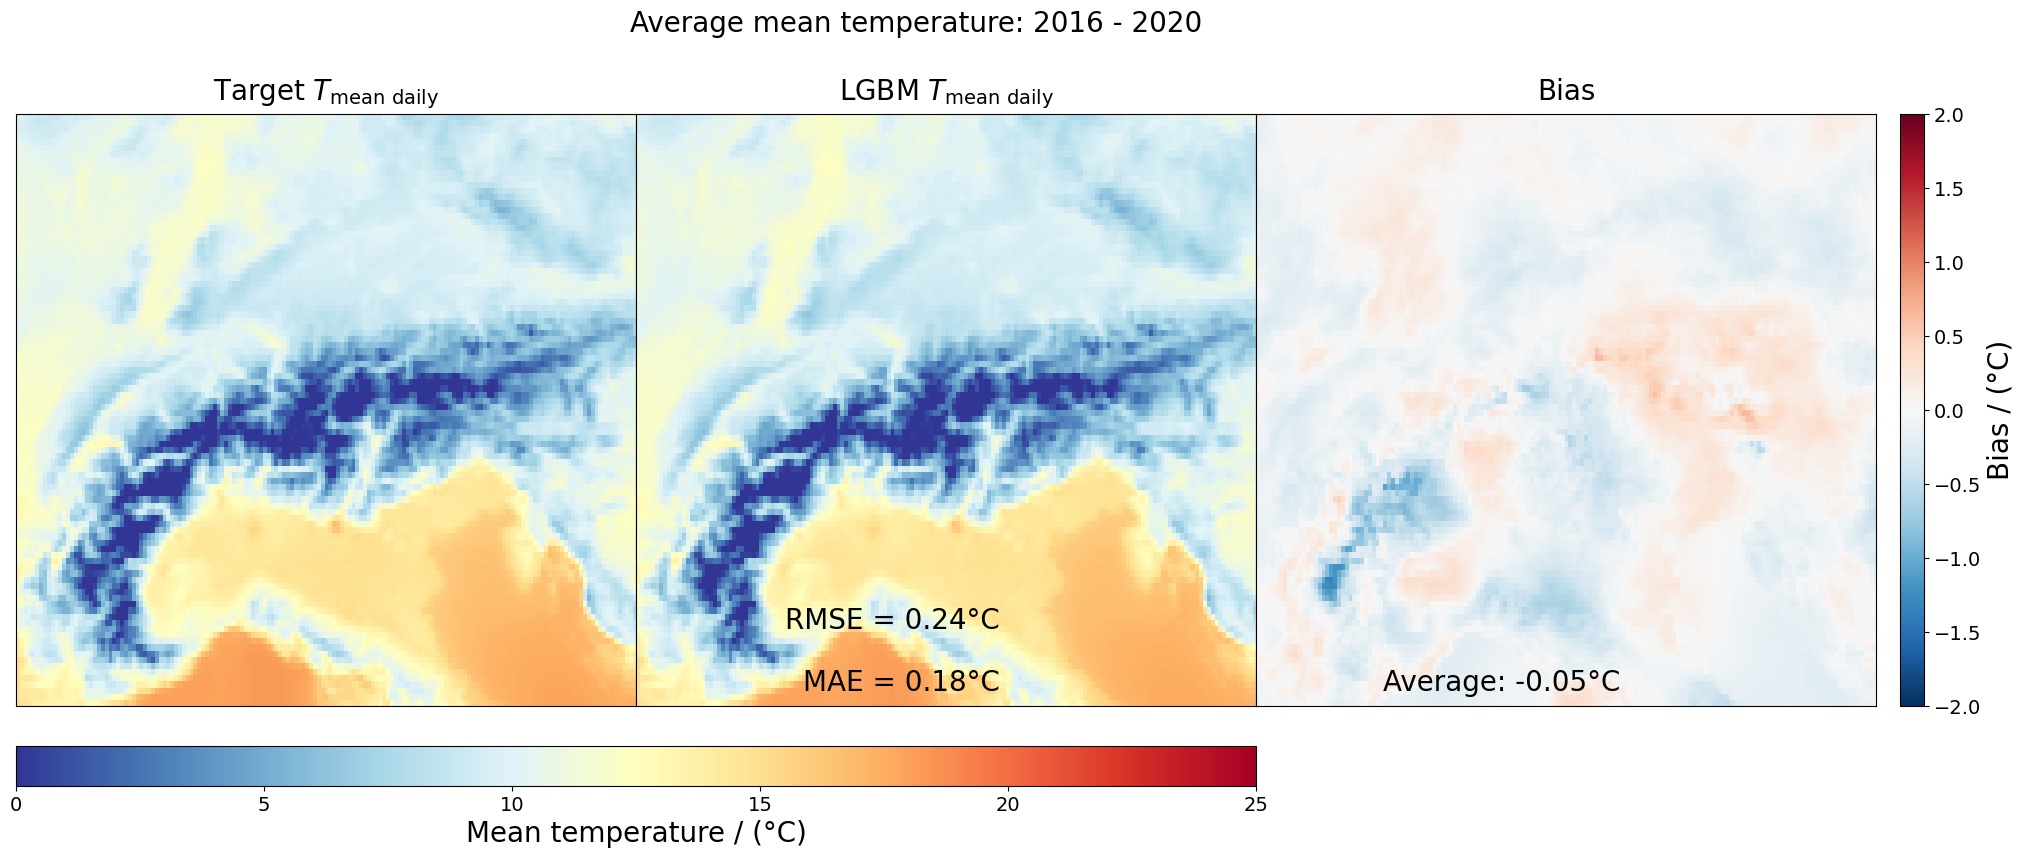

In [25]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=20, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=20, pad=10);
axes[1].set_title(PRED, fontsize=20, pad=10);
axes[2].set_title('Bias', fontsize=20, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=20)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=20)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=20, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=20, ha='right')

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

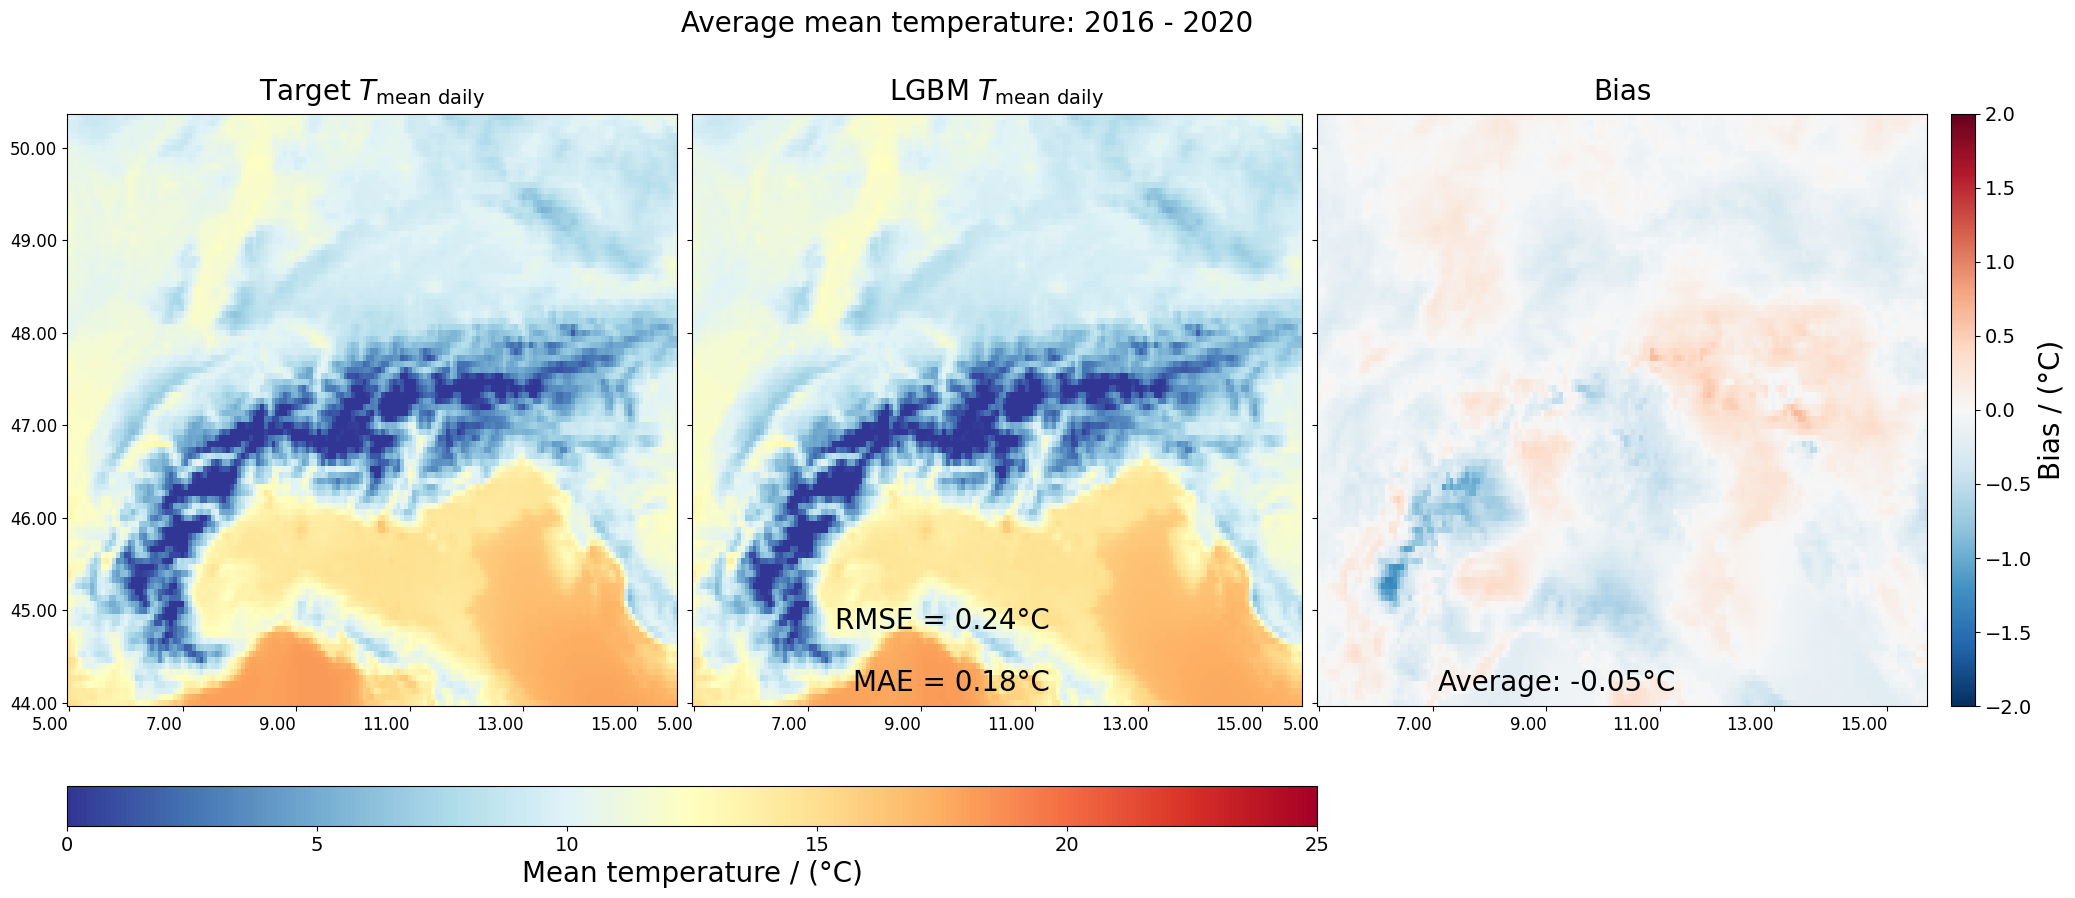

In [26]:
import matplotlib.pyplot as plt

coord = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/base_models/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2m_dem_doy.nc")    

# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=20, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=20, pad=10);
axes[1].set_title(PRED, fontsize=20, pad=10);
axes[2].set_title('Bias', fontsize=20, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

import numpy as np

# add latitude labels to left and right plots
lat_resolution = 15  # Specify the resolution in degrees
for ax in [axes[0], axes[-1]]:
    lat_values = coord.y.values
    lat_indices = [int(round(i)) for i in np.arange(0, len(lat_values), lat_resolution)]
    ax.set_yticks(lat_indices)
    ax.set_yticklabels(['{:.2f}'.format(int(round(lat_values[i]))) for i in lat_indices], fontsize=12)

# add longitude labels to all plots at the bottom
lon_resolution = 30  # Specify the resolution in degrees
for ax in axes:
    lon_values = coord.x.values
    lon_indices = [int(round(i)) for i in np.arange(0, len(lon_values), lon_resolution)]
    ax.set_xticks(lon_indices)
    ax.set_xticklabels(['{:.2f}'.format(int(round(lon_values[i]))) for i in lon_indices], fontsize=12, ha='right')



# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0.025, top=0.85)

# add colorbar for bias
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=20)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.15,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=20)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=20, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=20, ha='right')

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')


### Seasonal bias

Calculate seasonal bias:

In [27]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [28]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season DJF: -0.1°C
(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season JJA: -0.1°C
(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season MAM: -0.1°C
(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season SON: -0.0°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

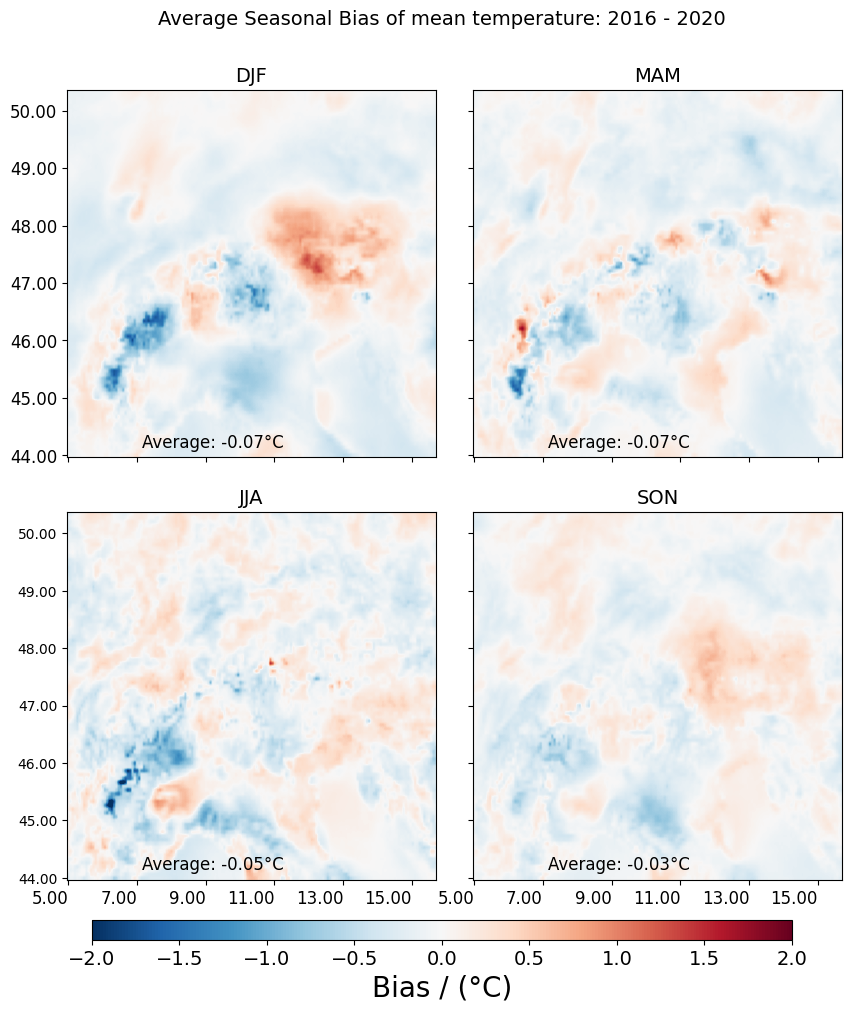

In [29]:
import matplotlib.pyplot as plt

# plot seasonal differences
seasons = ('DJF', 'MAM', 'JJA', 'SON')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

# plot seasonal average bias
for ax, season in zip(axes, seasons):
    ds = bias_snl.sel(season=season)
    im = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=14)
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=12, ha='right')

# adjust axes
for ax in axes:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# add latitude labels to left and right plots
lat_resolution = 15  # Specify the resolution in degrees
for ax in [axes[0], axes[-1]]:
    lat_values = coord.y.values
    lat_indices = [int(round(i)) for i in np.arange(0, len(lat_values), lat_resolution)]
    ax.set_yticks(lat_indices)
    ax.set_yticklabels(['{:.2f}'.format(int(round(lat_values[i]))) for i in lat_indices], fontsize=12)

# add longitude labels to all plots at the bottom
lon_resolution = 30  # Specify the resolution in degrees
for ax in axes:
    lon_values = coord.x.values
    lon_indices = [int(round(i)) for i in np.arange(0, len(lon_values), lon_resolution)]
    ax.set_xticks(lon_indices)
    ax.set_xticklabels(['{:.2f}'.format(int(round(lon_values[i]))) for i in lon_indices], fontsize=12, ha='right')

# adjust figure
fig.suptitle('Average Seasonal Bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=14)
fig.subplots_adjust(hspace=0.15, wspace=0.1, top=0.9)

# add colorbar at the bottom
cbar_ax_predictand = fig.add_axes([0.15, 0.05, 0.7, 0.02])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Bias / (°C)', fontsize=20)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

plt.show()


### Bias of extreme values

In [30]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [31]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [32]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [33]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average bias for P98 of tasmean: -0.1°C


In [34]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [35]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average MAE for P98 of tasmean: 0.5°C


In [36]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [37]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(Target $T_{\mathrm{mean \ daily}}$:LGBM $T_{\mathrm{mean \ daily}}$) Yearly average RMSE for P98 of tasmean: 0.7°C


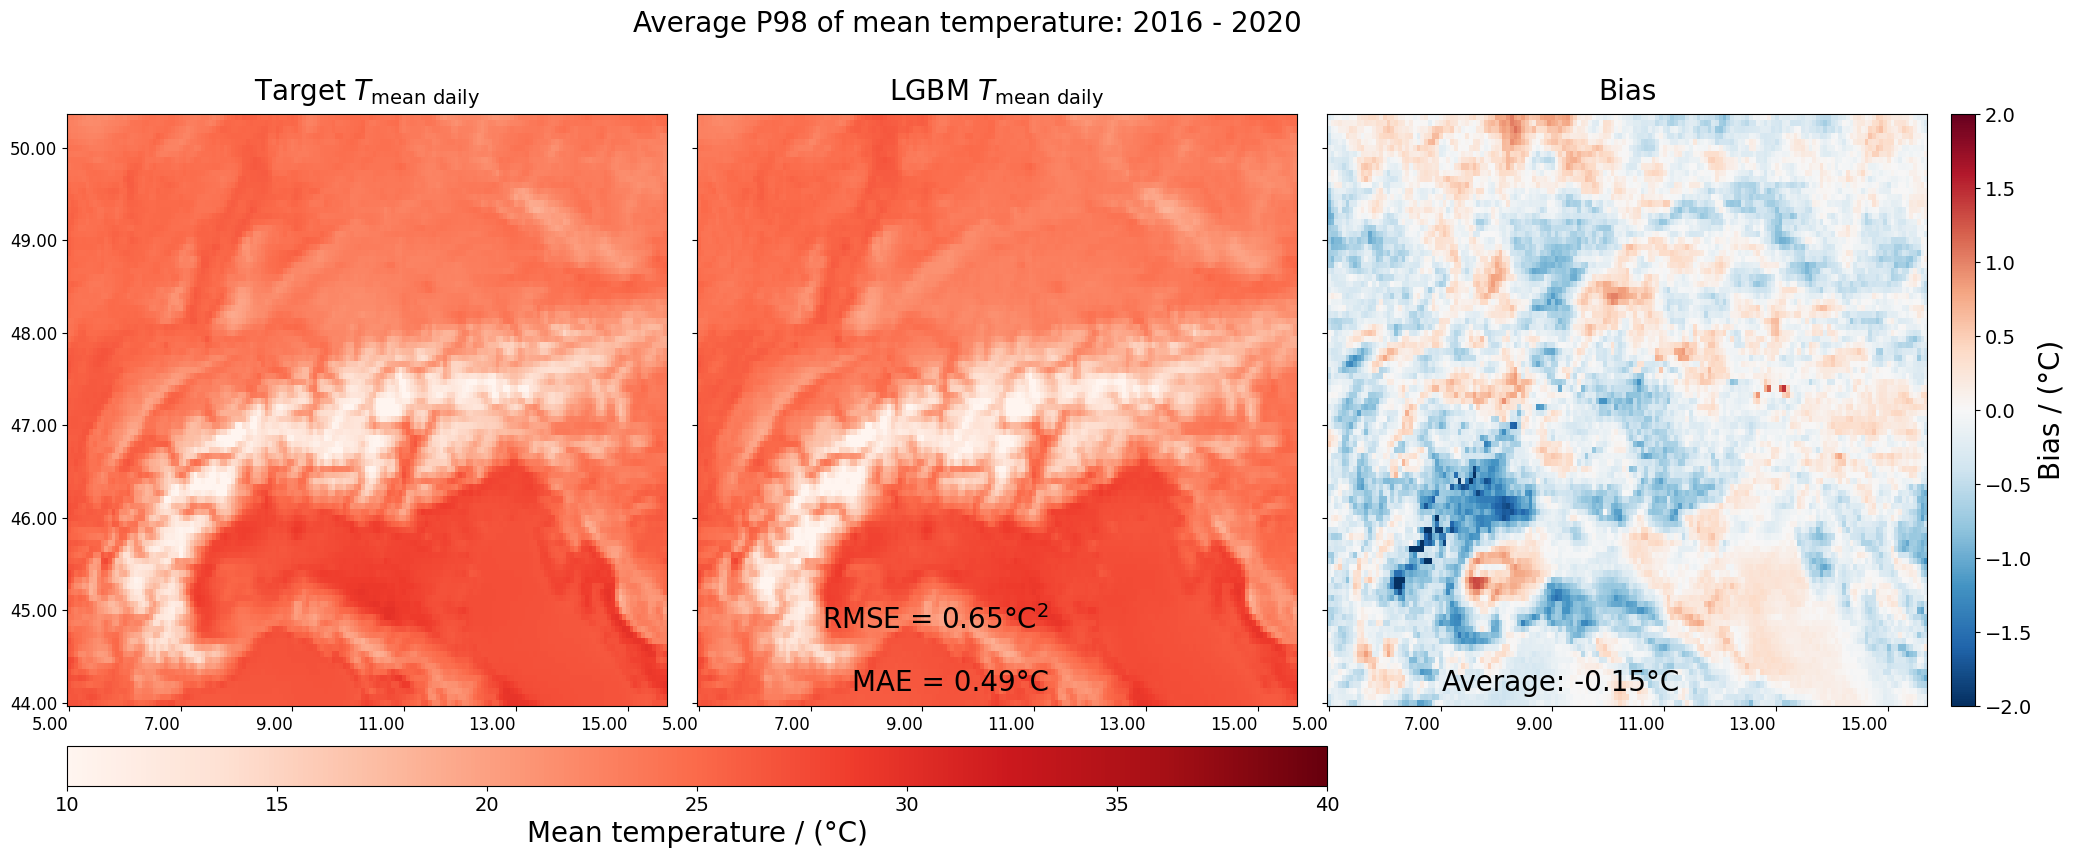

In [38]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=20, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=20, pad=10);
axes[1].set_title(PRED, fontsize=20, pad=10);
axes[2].set_title('Bias', fontsize=20, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# add latitude labels to left and right plots
lat_resolution = 15  # Specify the resolution in degrees
for ax in [axes[0], axes[-1]]:
    lat_values = coord.y.values
    lat_indices = [int(round(i)) for i in np.arange(0, len(lat_values), lat_resolution)]
    ax.set_yticks(lat_indices)
    ax.set_yticklabels(['{:.2f}'.format(int(round(lat_values[i]))) for i in lat_indices], fontsize=12)

# add longitude labels to all plots at the bottom
lon_resolution = 30  # Specify the resolution in degrees
for ax in axes:
    lon_values = coord.x.values
    lon_indices = [int(round(i)) for i in np.arange(0, len(lon_values), lon_resolution)]
    ax.set_xticks(lon_indices)
    ax.set_xticklabels(['{:.2f}'.format(int(round(lon_values[i]))) for i in lon_indices], fontsize=12, ha='right')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0.05, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=20)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=20)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=20, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=20, ha='right')

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

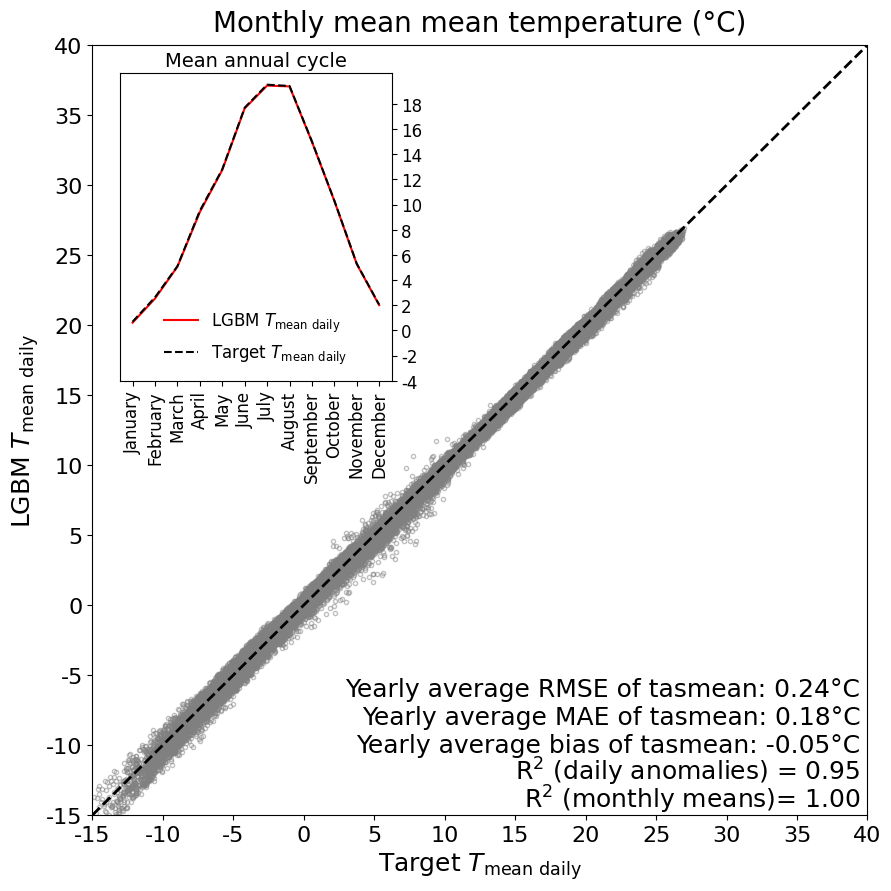

In [39]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('Target $T_{\mathrm{mean \ daily}}$', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=2)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='Target $T_{\mathrm{mean \ daily}}$')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/mslp.png', dpi=300, bbox_inches='tight')
